inspired by:

https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial

#### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import textwrap
import langid



In [2]:
import nltk

# Force re-download the punkt resource
nltk.download('punkt', force=True)
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('vader_lexicon')

# Check all available resources and their locations
print(nltk.data.path)

[nltk_data] Downloading package punkt to /Users/juliuseg/nltk_data...


['/Users/juliuseg/nltk_data', '/Users/juliuseg/DTU/CompTools/.venv/nltk_data', '/Users/juliuseg/DTU/CompTools/.venv/share/nltk_data', '/Users/juliuseg/DTU/CompTools/.venv/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/juliuseg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/juliuseg/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Trip advisor data
stopwords is removed already. So im not sure if transformers will be worse here?

In [3]:
# Read in data
df_full = pd.read_csv('data/tripadvisor_hotel_reviews.csv')
print(df_full.shape)
df = df_full.head(500)
df = df.reset_index()
print(df.shape)


(20491, 2)
(500, 3)


In [ ]:
# Prune language of dataframe
df = df[df["Review"].apply(lambda x: langid.classify(str(x))[0] == "en")]

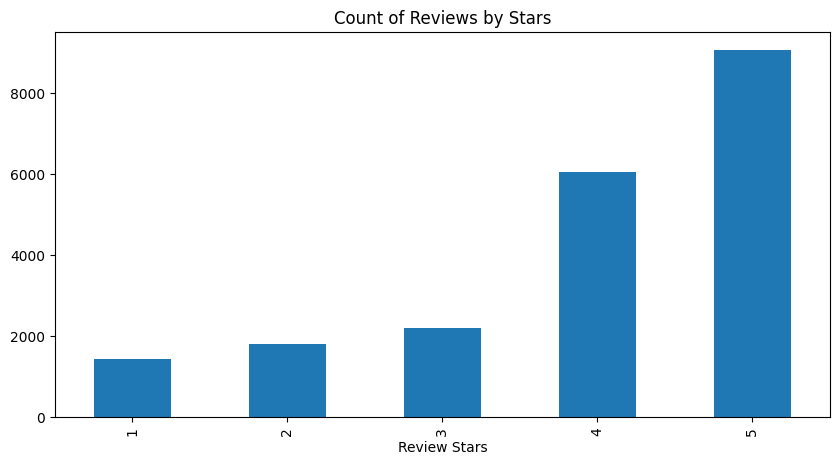

In [5]:
ax = df_full['Rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()



In [6]:
example = df['Review'][0]
print(example)

nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  


### Tokens

In [7]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['nice',
 'hotel',
 'expensive',
 'parking',
 'got',
 'good',
 'deal',
 'stay',
 'hotel',
 'anniversary']

In [8]:
tagged = nltk.pos_tag(tokens) # See meanings here https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
tagged[:10]

[('nice', 'JJ'),
 ('hotel', 'NN'),
 ('expensive', 'JJ'),
 ('parking', 'NN'),
 ('got', 'VBD'),
 ('good', 'JJ'),
 ('deal', 'NN'),
 ('stay', 'VB'),
 ('hotel', 'NN'),
 ('anniversary', 'NN')]

### Dictionary approach (VADER)

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()


In [10]:
temp = sia.polarity_scores(example)
print (example)
print (temp)

nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  
{'neg': 0.072, 'neu': 0.643, 'pos': 0.285, 'compound': 0.9747}


In [11]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Review']
    myid = row['index']
    res[myid] = sia.polarity_scores(text)



  0%|          | 0/500 [00:00<?, ?it/s]

In [12]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'index'})
vaders = vaders.merge(df, how='left')

In [13]:
vaders.head()

,index,neg,neu,pos,compound,Review,Rating
0,0,0.072,0.643,0.285,0.9747,nice hotel expensive parking got good deal sta...,4
1,1,0.110,0.701,0.189,0.9787,ok nothing special charge diamond member hilto...,2
2,2,0.081,0.700,0.219,0.9889,nice rooms not 4* experience hotel monaco seat...,3
3,3,0.060,0.555,0.385,0.9912,"unique, great stay, wonderful time hotel monac...",5
4,4,0.135,0.643,0.221,0.9797,"great stay great stay, went seahawk game aweso...",5


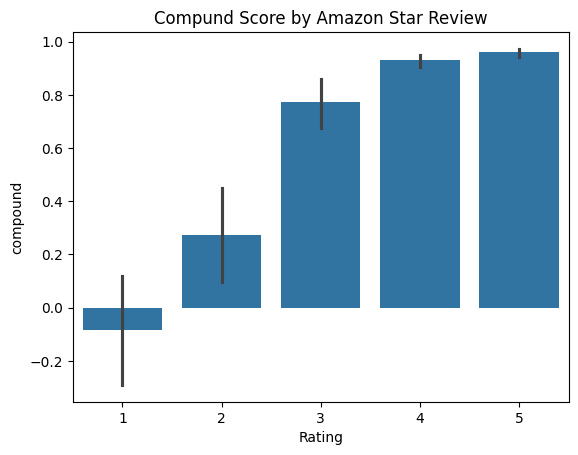

In [ ]:
ax = sns.barplot(data=vaders, x='Rating', y='compound')
ax.set_title('Compund Score by Amazon Star Review') # Method taken from kaggle as described. 
plt.show()


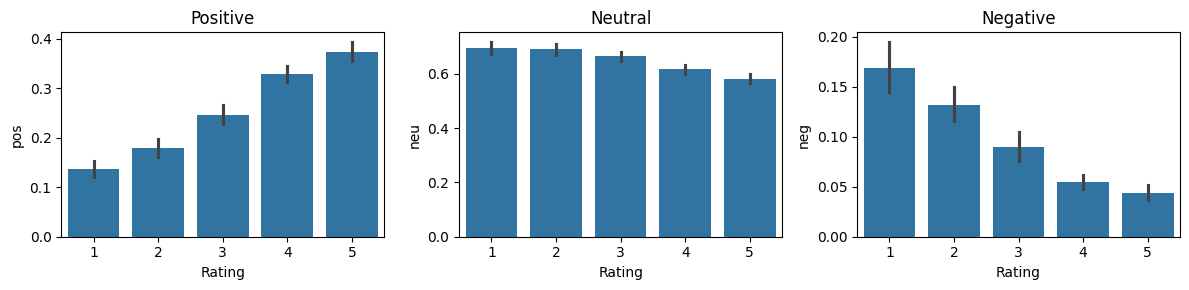

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()



### Pretrained transformer model (Roberta)

In [16]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax



In [17]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Because im using my mac m2 where metal is gpu framework (Like cuda for nvidia)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model.to(device)

mps


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [18]:
# VADER results on example for comparison
print(example)
print(sia.polarity_scores(example))

# Roberta
# Tokenize and move tensors to the same device as model
encoded_text = tokenizer(example, return_tensors="pt")
encoded_text = {k: v.to(device) for k, v in encoded_text.items()}

# Run inference safely on MPS
with torch.no_grad():
    output = model(**encoded_text)

# Move result to CPU for numpy operations
scores = output.logits[0].to("cpu").numpy()
scores = softmax(scores)

scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}
print({k: round(float(v), 3) for k, v in scores_dict.items()})

nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  
{'neg': 0.072, 'neu': 0.643, 'pos': 0.285, 'compound': 0.9747}
{'roberta_neg': 0.019, 'roberta_neu': 0.104, 'roberta_pos': 0.876}


#### Function to use to do entire dataset

In [19]:
def polarity_scores_roberta(example):
    # Tokenize and move to correct device
    encoded_text = tokenizer(example, return_tensors="pt")
    encoded_text = {k: v.to(device) for k, v in encoded_text.items()}

    # Inference
    with torch.no_grad():
        output = model(**encoded_text)

    # Move back to CPU for numpy conversion
    scores = output.logits[0].to("cpu").numpy()
    scores = softmax(scores)

    # Convert to normal floats
    return {
        'roberta_neg': float(scores[0]),
        'roberta_neu': float(scores[1]),
        'roberta_pos': float(scores[2])
    }


In [20]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Review']
        myid = row['index']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 344
Broke for id 442
Broke for id 487


In [21]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'index'})
results_df = results_df.merge(df, how='left')
results_df.columns

Index(['index', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'Review', 'Rating'],
      dtype='object')

### Examples

In [22]:
q = results_df.query('Rating == 1') \
    .sort_values('roberta_pos', ascending=False)['Review'].values[0]

print(textwrap.fill(q, width=85))
    

stay away dirty rooms stayed far better places seattle, room size prison cell window
facing outside wall, quiet showered flushed toilet, plus seattle best coffee lobby
right downtown, hotel limo expect pay 30 yellow cab, hotel staff helpful friendly,


In [23]:
q = results_df.query('Rating == 1') \
    .sort_values('vader_pos', ascending=False)['Review'].values[0]

print(textwrap.fill(q, width=85))

stay plenty nice hotels seattle, not, terrible stay bellman lost luggage phones did
n't work dirty sheets letter manager answered acknowledged, better staying,


In [24]:
q = results_df.query('Rating == 5') \
    .sort_values('roberta_neg', ascending=False)['Review'].values[0]

print(textwrap.fill(q, width=85))


max-imum enjoyment, co-worker stayed hotel max semi-business trip decided share room
save company dollars mindful watch company money, max high end price wise typically
pay traveling pleasure competetive downtown seattle hotels priceline spoiled years
150 night like splurge, called ahead confirm late check double check set reserved
room 2 beds a-ok. arrival greeted attentive desk clerk went looking bottled water,
experiencing smooth check soon way 8th floor room, impressions room far larger
expected, course seen room complaints regarding size norm reviews hotel, wardrobe
plenty spacious taken particular note mentioned hang clothes angle room wardrobe
question large clothes, downfall room non-smoking non-smoking floor clearly home
guests realize cigarette smoke smells lingers, probably adjusted co-worker
particularly sensative problem, attempted switch rooms informed hotel booked wait
morning, effort rid room reek opened windows helped bit, beds laden white
comforters/duvets loads pillo

In [25]:

q = results_df.query('Rating == 5') \
    .sort_values('vader_neg', ascending=False)['Review'].values[0]

print(textwrap.fill(q, width=85))



great seattle location great downtown hotel, parking problem, read reviews hotel
parking 35 overnite, parked block away convention center 18.short 6 block walk pike
place market, n't miss excellent dinner hotel daily grill definitely stay,
